<a href="https://colab.research.google.com/github/ikoghoemmanuell/Azubi-Store-Sales-Review-/blob/main/ISOT_EDA_%26_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection Using Machine Learning and Deep Learning Models

This notebook aims to classify fake news from real news.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer # Import for transforming text into numerical features using TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Deep Learning
import tensorflow as tf  # Import TensorFlow library for deep learning tasks
import keras  # Import Keras library for building neural networks
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Import for padding sequences
from keras.models import Model, Sequential  # Import for defining neural network models
from keras.layers import Input, Dense, Activation, Bidirectional, LSTM, Dropout, Embedding  # Import for different layers in neural networks
from keras.preprocessing.text import Tokenizer  # Import for tokenizing text
from keras.preprocessing import sequence  # Import for processing sequences
from keras.callbacks import EarlyStopping  # Import for early stopping during model training

# Configuring TensorFlow logging
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Set TensorFlow logging verbosity to error level

# Text processing
from wordcloud import WordCloud  # Import for generating word clouds

# Mounting Google Drive
from google.colab import drive  # Import for accessing Google Drive

# Unzipping files
import zipfile  # Import for extracting zip files


Read the data

In [2]:
# Mount your Google Drive
drive.mount('/content/drive')

# Get the file path from Google Drive
file_path = '/content/drive/MyDrive/fake news/archive (2).zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # Find the CSV files in the zip folder
    fake_path = zip_ref.extract('Fake.csv', '/content/')
    real_path = zip_ref.extract('True.csv', '/content/')

# Read the csv file from the url
fake_df = pd.read_csv(fake_path)
real_df = pd.read_csv(real_path)

# A way to delete rows with empty or null values
fake_df = fake_df[~fake_df.isna().any(axis=1)]
real_df = real_df[~real_df.isna().any(axis=1)]

Mounted at /content/drive


Checking for null values

In [3]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [4]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

Checking for unique values for subject. We want both data frames to have a similar distribution.

In [5]:
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [6]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

Drop the date from the dataset, I don't think there is a strong correlation between date and validity of the news. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well.

In [7]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

0 for fake news, and 1 for real news

In [8]:
fake_df['class'] = 0
real_df['class'] = 1

## EDA

Check out the distribution of fake news compare to real news

Text(0, 0.5, 'Proportion of News Articles')

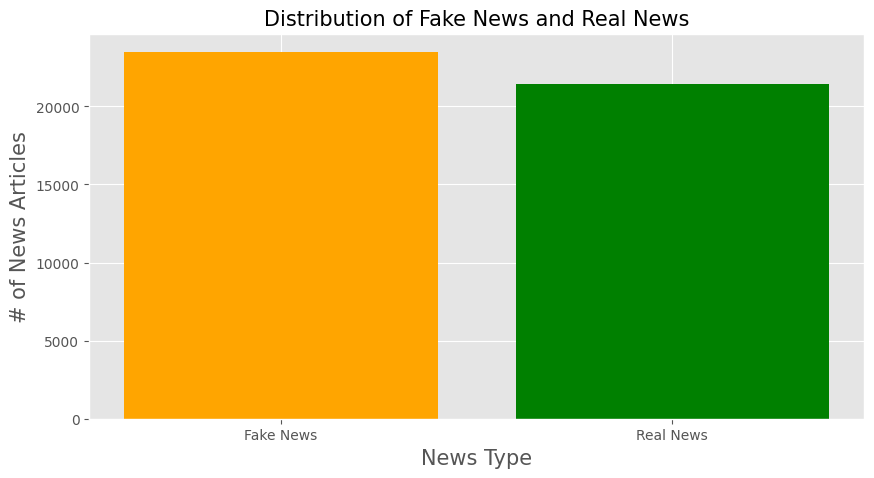

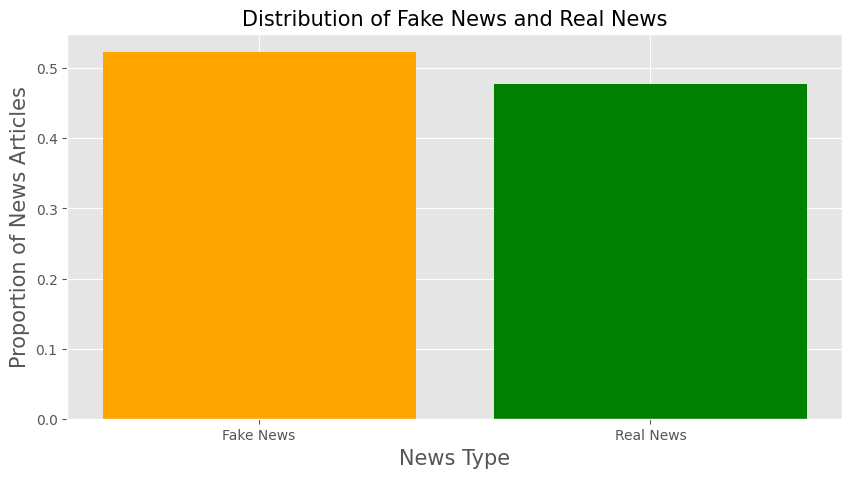

In [9]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [10]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [11]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


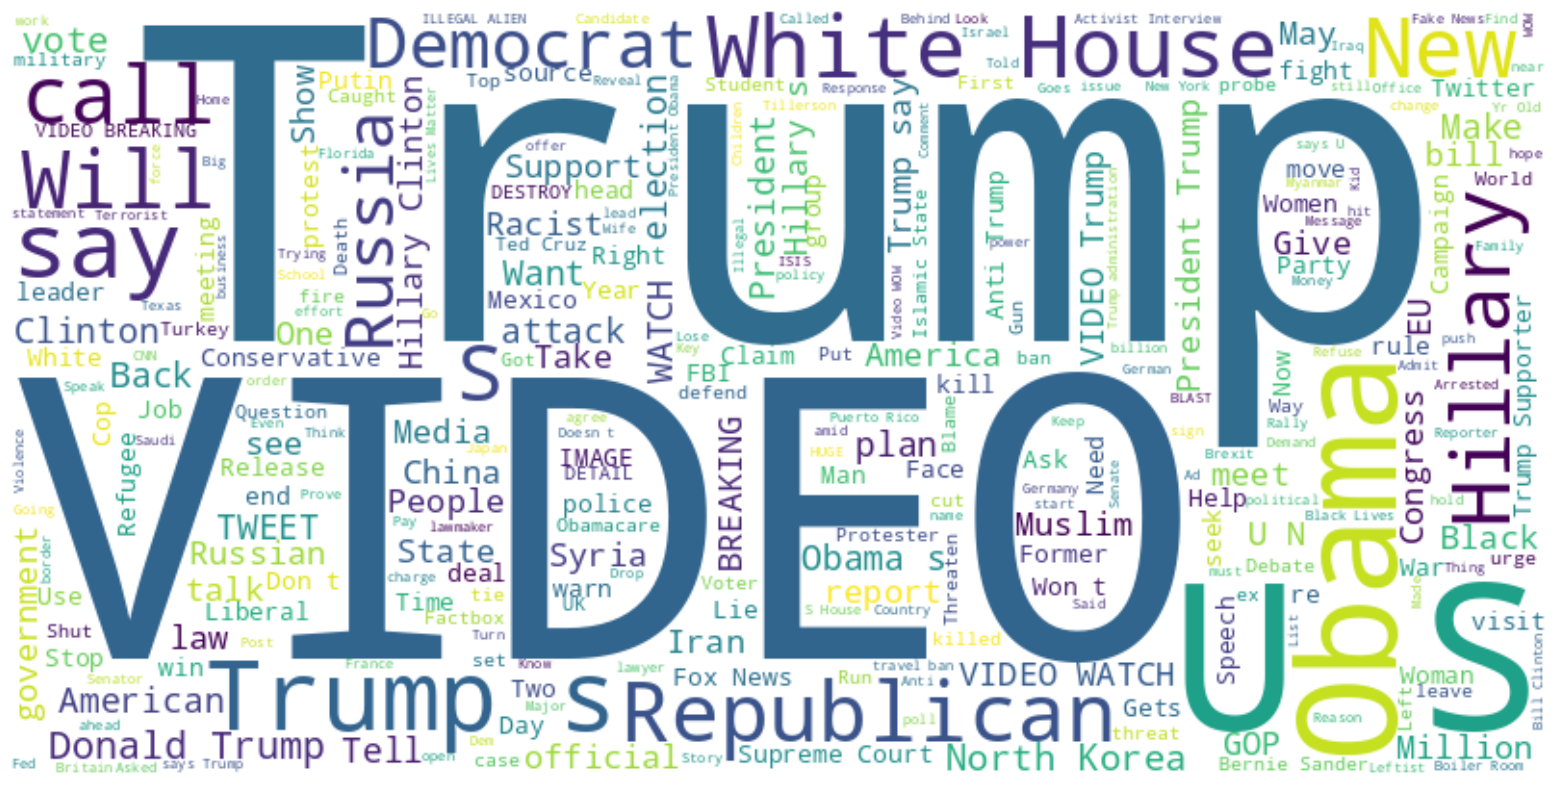

In [12]:
# Concatenate all the titles from the 'title' column in the DataFrame into a single string
titles = ' '.join(title for title in news_df['title'])

# Create a WordCloud object with specified configurations
wordcloud = WordCloud(
    background_color='white',  # Set the background color of the word cloud to white
    max_words=300,  # Set the maximum number of words to be displayed in the word cloud
    width=800,  # Set the width of the word cloud figure
    height=400  # Set the height of the word cloud figure
).generate(titles)  # Generate the word cloud based on the concatenated titles

# Display the word cloud figure
plt.figure(figsize=(20, 10))  # Set the size of the figure to display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud with bilinear interpolation
plt.axis("off")  # Turn off the axis labels and ticks
plt.show()  # Show the word cloud figure

In [13]:
news_df['num_words'] = news_df['text'].apply(lambda x: len(x.split()))

<ipython-input-14-f4a93ea9bb73>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(news_df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)


Text(0.5, 1.0, 'Distribution of the News Words count')

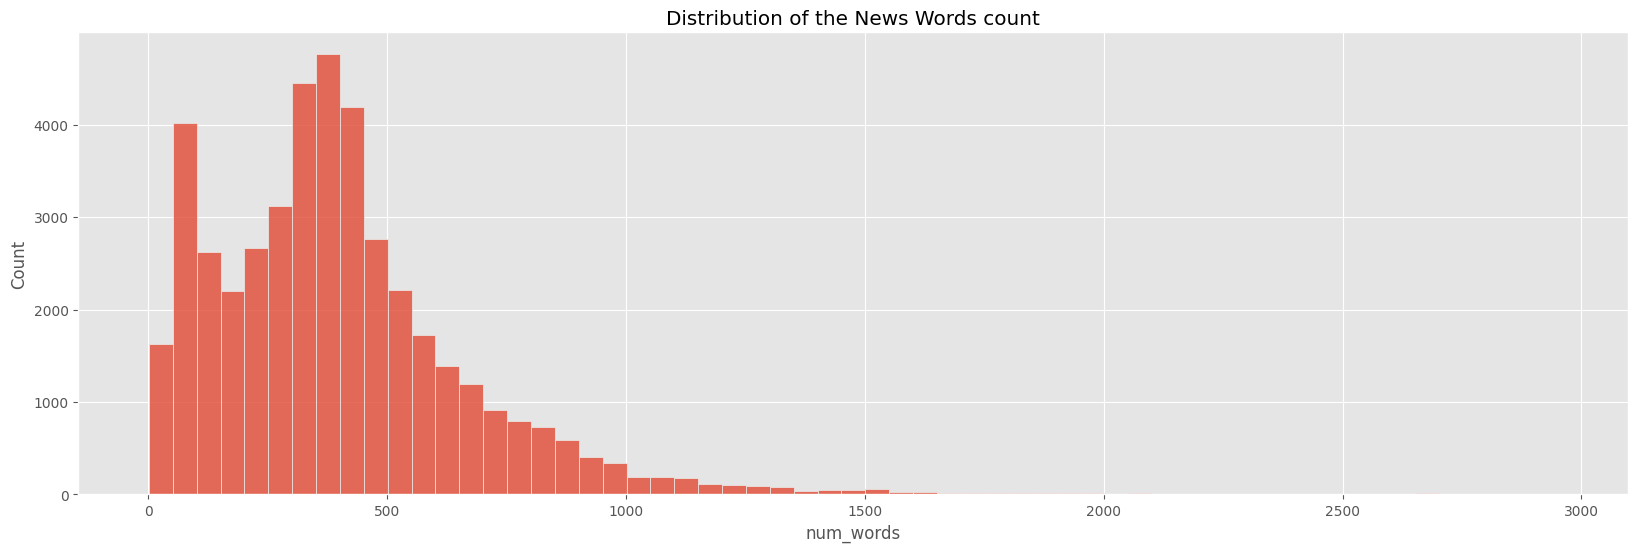

In [14]:
plt.figure(figsize = (20,6))
sns.histplot(news_df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the News Words count')

Combining the title with the text, it is much easier to process this way.

In [15]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

Split into training and testing

In [16]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

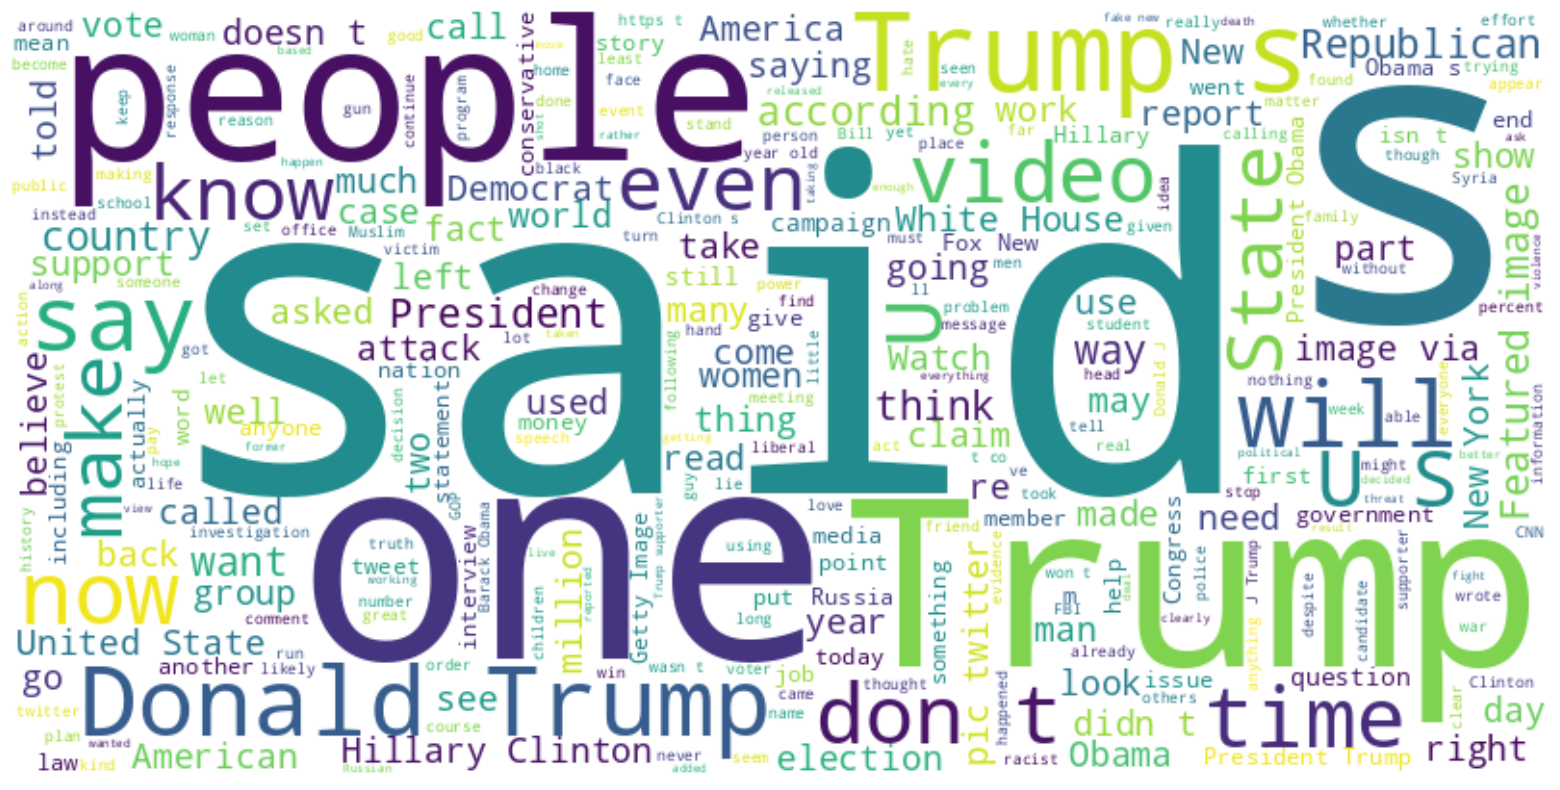

In [17]:
fake_news = X_train[y_train == 0]
real_news = X_train[y_train == 1]
fake_texts = ' '.join(text for text in fake_news)
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(fake_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The above is a plot of the most frequent words in fake news set

# Machine Learning

### RNN

Normalizing our data: lower case, get rid of extra spaces, and url links.

In [18]:
# Function to replace usernames and links with placeholders.
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Normalize the text data in X_train and X_test using the preprocess() function
X_train = [preprocess(text) for text in X_train]
X_test = [preprocess(text) for text in X_test]

In [19]:
# define tokenizer and fit it
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data.

In [20]:
# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article

In [21]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Building the RNN.

In [22]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 128),  # Embedding layer for word representation
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),  # Bidirectional LSTM layer with 64 units, returns sequences
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),  # Bidirectional LSTM layer with 16 units
    tf.keras.layers.Dense(64, activation='relu'),  # Fully connected dense layer with 64 units and ReLU activation
    tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(1)  # Output layer with 1 unit (binary classification)
])

# Print the summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

We are going to use early stop, which stops when the validation loss no longer improve.

In [23]:
# Define EarlyStopping callback to monitor validation loss and restore best weights
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss for early stopping
    patience=2,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best model found during training
)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Binary cross-entropy loss for binary classification problem
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Adam optimizer with a learning rate of 1e-4
    metrics=['accuracy']  # Accuracy metric to monitor during training
)

# Train the model on the training data with validation split, batch size, shuffling, and EarlyStopping callback
history = model.fit(
    X_train,                    # Training data
    y_train,                    # Training labels
    epochs=10,                  # Number of training epochs
    validation_split=0.1,        # Fraction of the training data to be used for validation
    batch_size=30,              # Batch size for training
    shuffle=True,               # Shuffle the training data before each epoch
    callbacks=[early_stop]      # List of callbacks to be used during training (EarlyStopping in this case)
)

Epoch 1/10
1078/1078 [==============================] - 135s 111ms/step - loss: 0.2174 - accuracy: 0.8927 - val_loss: 0.0356 - val_accuracy: 0.9911
Epoch 2/10
1078/1078 [==============================] - 52s 48ms/step - loss: 0.0284 - accuracy: 0.9941 - val_loss: 0.0253 - val_accuracy: 0.9933
Epoch 3/10
1078/1078 [==============================] - 46s 42ms/step - loss: 0.0143 - accuracy: 0.9966 - val_loss: 0.0212 - val_accuracy: 0.9942
Epoch 4/10
1078/1078 [==============================] - 41s 38ms/step - loss: 0.0086 - accuracy: 0.9982 - val_loss: 0.0411 - val_accuracy: 0.9886
Epoch 5/10
1078/1078 [==============================] - 42s 39ms/step - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.0355 - val_accuracy: 0.9905


Evaluate the testing set

In [24]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 4s 14ms/step - loss: 0.0220 - accuracy: 0.9929


[0.02195965312421322, 0.9928730726242065]

In [25]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

281/281 [==============================] - 5s 13ms/step


In [26]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('F1 score on testing set:', f1_score(binary_predictions, y_test))

Accuracy on testing set: 0.9928730512249443
F1 score on testing set: 0.9926096997690531


# Deep Learning

### LSTM

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify = targets, random_state = 10)

In [28]:
#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

Train vocabulary size: 145655


In [30]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = pad_sequences(test_sequences,maxlen=MAX_LEN)

In [31]:
# Define the model architecture
model = tf.keras.Sequential([
    Input(name='inputs', shape=[MAX_LEN]),  # Define input layer with specified shape
    Embedding(len(tok.word_index), 128),  # Add an embedding layer with a specified vocabulary size and embedding dimension
    Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),  # Add a bidirectional LSTM layer with 128 units and return sequences
    Bidirectional(tf.keras.layers.LSTM(64)),  # Add another bidirectional LSTM layer with 64 units
    Dense(64, activation='relu'),  # Add a dense layer with 64 units and ReLU activation function
    Dropout(0.5),  # Add a dropout layer with a dropout rate of 0.5 to prevent overfitting
    Dense(1, activation='sigmoid')  # Add a dense layer with 1 unit and sigmoid activation for binary classification
])

# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),  # Use binary cross-entropy as the loss function
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Use Adam optimizer with a learning rate of 1e-4
    metrics=['accuracy']  # Track accuracy as a metric during training
)

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 128)          18643840  
                                                                 
 bidirectional_2 (Bidirectio  (None, 512, 256)         263168    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

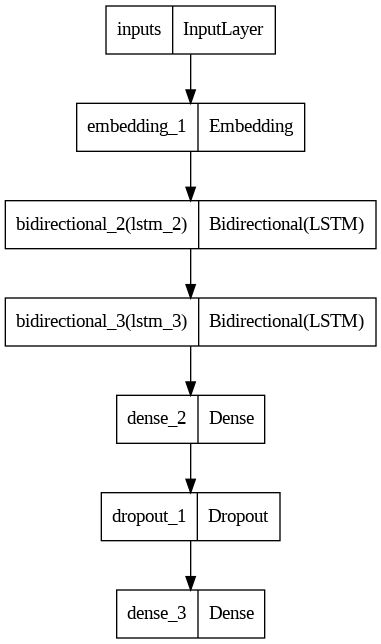

In [32]:
#plot the model architecture
tf.keras.utils.plot_model(model)

In [33]:
# Training the model and storing the training history

history = model.fit(
    X_train_seq,  # Training data (input sequences)
    y_train,  # Training data labels (target variable)
    epochs=10,  # Number of training epochs
    validation_split=0.2,  # Percentage of training data used for validation
    batch_size=64,  # Number of samples per gradient update
    callbacks=[EarlyStopping(
        monitor='val_accuracy',  # Metric to monitor for early stopping (validation accuracy)
        mode='max',  # Maximizing the monitored metric
        patience=3,  # Number of epochs to wait for improvement before stopping
        verbose=False,  # Suppresses output during training
        restore_best_weights=True  # Restores weights of the model from the epoch with the best monitored metric
    )]
)

Epoch 1/10
421/421 [==============================] - 120s 268ms/step - loss: 0.2229 - accuracy: 0.9080 - val_loss: 0.0315 - val_accuracy: 0.9912
Epoch 2/10
421/421 [==============================] - 79s 187ms/step - loss: 0.0231 - accuracy: 0.9947 - val_loss: 0.0269 - val_accuracy: 0.9926
Epoch 3/10
421/421 [==============================] - 66s 157ms/step - loss: 0.0101 - accuracy: 0.9981 - val_loss: 0.0355 - val_accuracy: 0.9920
Epoch 4/10
421/421 [==============================] - 61s 145ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 0.0230 - val_accuracy: 0.9944
Epoch 5/10
421/421 [==============================] - 53s 126ms/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.0237 - val_accuracy: 0.9945
Epoch 6/10
421/421 [==============================] - 50s 119ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0335 - val_accuracy: 0.9929
Epoch 7/10
421/421 [==============================] - 48s 115ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.0383 - val_a

In [34]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

351/351 [==============================] - 11s 27ms/step
Test Loss: 0.02219066396355629
Test Accuracy: 0.9942984580993652


In [35]:
## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5871
           1       1.00      0.99      0.99      5354

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



## Logistic Regression

In [36]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

In [37]:
LR = LogisticRegression()
LR.fit(xv_train,y_train)

LogisticRegression()

In [38]:
pred_lr=LR.predict(xv_test)

In [39]:
LR.score(xv_test, y_test)

0.9879732739420936

In [40]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5871
           1       0.98      0.99      0.99      5354

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



## Random Forest Classifier

In [41]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)

RandomForestClassifier(random_state=0)

In [42]:
RFC.score(xv_test, y_test)

0.9915367483296214

In [43]:
pred_rfc = RFC.predict(xv_test)

In [44]:
pred_rfc = RFC.predict(xv_test)
RFC.score(xv_test, y_test)

0.9915367483296214

In [45]:
RFC.score(xv_test, y_test)

0.9915367483296214

In [46]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5871
           1       0.99      0.99      0.99      5354

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

